In [1]:
!pip install keras-tuner

In [2]:
!pip install eli5

In [3]:
# Import our dependencies
import pandas as pd
import matplotlib as plt
import sklearn as skl
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib # dumping RFModel
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Load in features dataset
file_path = "../Resources/cleaned_athlete_gdp_sanction_data.csv"
athletes_df = pd.read_csv(file_path)
athletes_df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Medal_Type,Medal,Row,Employment,Population,UnemploymentRate,GDP,DateofInfraction,IneligibilityUntil,LifetimeBan
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,No_Medal,N,2,0.000,1171.710,2.300,492.155,0.0,0.0,0.0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,...,No_Medal,N,3,0.000,1354.040,4.090,8539.470,0.0,0.0,0.0
2,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,...,No_Medal,N,4,6.093,14.715,6.247,264.223,0.0,0.0,0.0
3,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,...,No_Medal,N,5,6.093,14.715,6.247,264.223,0.0,0.0,0.0
4,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,...,No_Medal,N,6,6.648,15.129,4.865,366.004,0.0,0.0,0.0


In [5]:
# Load in features dataset
file_path = "../data/host_cities.csv"
host_df = pd.read_csv(file_path)
host_df.head()

,Host City,Host Country
0,Barcelona,ESP
1,London,GBR
2,Antwerpen,BEL
3,Paris,FRA
4,Calgary,CAN


In [6]:
# Merge athletes and host citiy dataframes and create new dataframe
olympics_df = athletes_df.merge(host_df, left_on="City", right_on="Host City")
# Binary classifiers for Season, Home Field Advantage
olympics_df['Home_Field_Adv'] = np.where(olympics_df['Host Country'] == olympics_df['NOC'], 1, 0)
olympics_df['Summer'] = np.where(olympics_df['Season'] == 'Summer', 1, 0)

# Tackle classification problem of gender
olympics_df['Male'] = olympics_df['Sex'] == '1'

# Convert to integers
olympics_df['Home_Field_Adv'].astype('int64')
olympics_df['Summer'].astype('int64')
olympics_df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,UnemploymentRate,GDP,DateofInfraction,IneligibilityUntil,LifetimeBan,Host City,Host Country,Home_Field_Adv,Summer,Male
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,2.300,492.155,0.0,0.0,0.0,Barcelona,ESP,0,1,False
1,33,Mika Lauri Aarnikka,M,24.0,187.0,76.0,Finland,FIN,1992 Summer,1992,...,11.800,113.134,0.0,0.0,0.0,Barcelona,ESP,0,1,False
2,43,Morten Gjerdrum Aasen,M,34.0,185.0,75.0,Norway,NOR,1992 Summer,1992,...,5.915,130.838,0.0,0.0,0.0,Barcelona,ESP,0,1,False
3,50,Arvi Aavik,M,22.0,185.0,106.0,Estonia,EST,1992 Summer,1992,...,0.000,0.000,0.0,0.0,0.0,Barcelona,ESP,0,1,False
4,71,Juan Antonio Aball Delgado,M,27.0,172.0,82.0,Cuba,CUB,1992 Summer,1992,...,0.000,0.000,0.0,0.0,0.0,Barcelona,ESP,0,1,False


In [7]:
athletes_df = pd.DataFrame(olympics_df.groupby(['Games','NOC','Male','Team','Year','GDP','Population','Home_Field_Adv','Summer'])['Sport', 'Event','Medal'].nunique())
athletes_df = athletes_df.reset_index()
athletes_df.head()

D:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Games,NOC,Male,Team,Year,GDP,Population,Home_Field_Adv,Summer,Sport,Event,Medal
0,1964 Summer,AFG,False,Afghanistan,1964,0.0,0.0,0,1,1,2,1
1,1964 Summer,AHO,False,Netherlands Antilles,1964,0.0,0.0,0,1,2,4,1
2,1964 Summer,ALG,False,Algeria,1964,0.0,0.0,0,1,1,7,1
3,1964 Summer,ARG,False,Argentina,1964,0.0,0.0,0,1,14,74,2
4,1964 Summer,ARG,False,Rampage,1964,0.0,0.0,0,1,1,1,1


# Athlete Participation over the years

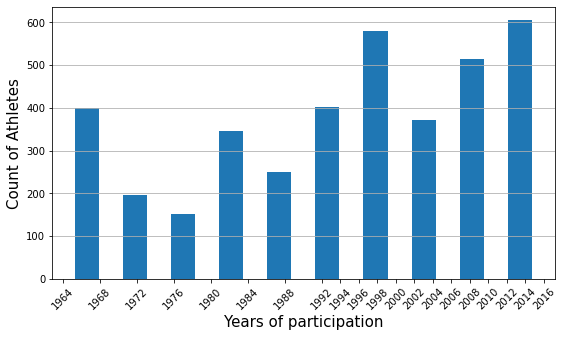

In [8]:
plt.figure(figsize=(9,5))
x = athletes_df.Year
plt.hist(x, density=False, rwidth = .5)
my_xticks = sorted(set(x))
plt.xlabel('Years of participation', fontsize=15)
plt.ylabel('Count of Athletes', fontsize=15)

plt.xticks(my_xticks, visible=True, rotation=45)
plt.grid(axis='y')

In [9]:
athletes_df.dtypes

Games              object
NOC                object
Male                 bool
Team               object
Year                int64
GDP               float64
Population        float64
Home_Field_Adv      int64
Summer              int64
Sport               int64
Event               int64
Medal               int64
dtype: object

# Custom Encoding

In [10]:
# Generate our categorical variable list
athletes_df.drop(athletes_df.loc[athletes_df['GDP']==0].index, inplace=True)
athletes_df.drop(athletes_df.loc[athletes_df['Population']==0].index, inplace=True)
athletes_df.drop(columns = {'Games','Team','Year'}, axis=1, inplace=True)
#athletes_df.drop(columns = {'Medal_Type'}, axis=1, inplace=True)
athletes_cat = athletes_df.dtypes[athletes_df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
athletes_df[athletes_cat].nunique()

NOC    185
dtype: int64

In [11]:
# Unique values of NOC
print(len(athletes_df['NOC'].unique()))
athletes_df['NOC'].unique()

185


array(['ALG', 'ANG', 'AUS', 'AUT', 'BEL', 'BEN', 'BOT', 'BRA', 'BUL',
       'CMR', 'COL', 'CRC', 'CYP', 'DEN', 'DOM', 'ECU', 'ESP', 'ETH',
       'FIN', 'FRA', 'GBR', 'GRE', 'GUA', 'GUY', 'HUN', 'IND', 'IRL',
       'ISL', 'ITA', 'JAM', 'JOR', 'KUW', 'LAO', 'LES', 'LIB', 'LUX',
       'MAD', 'MEX', 'MLI', 'MOZ', 'NED', 'NEP', 'NZL', 'PER', 'POL',
       'POR', 'PUR', 'ROU', 'SEN', 'SEY', 'SLE', 'SRI', 'SUI', 'SWE',
       'SYR', 'TAN', 'TTO', 'UGA', 'VEN', 'VIE', 'ZAM', 'ARG', 'BOL',
       'CAN', 'CHN', 'JPN', 'KOR', 'NOR', 'USA', 'ANT', 'BAN', 'BAR',
       'BHU', 'BIZ', 'BRN', 'CAF', 'CHA', 'CHI', 'CIV', 'COD', 'EGY',
       'ESA', 'FIJ', 'GAB', 'GEQ', 'GHA', 'GRN', 'HAI', 'HKG', 'HON',
       'INA', 'ISR', 'KEN', 'KSA', 'MAR', 'MAS', 'MAW', 'MRI', 'NIG',
       'OMA', 'PAK', 'PAN', 'PAR', 'PHI', 'PNG', 'QAT', 'RWA', 'SGP',
       'SOL', 'SUD', 'SWZ', 'THA', 'TOG', 'TUN', 'TUR', 'URU', 'BUR',
       'IRI', 'LBA', 'MDV', 'TGA', 'UAE', 'VAN', 'ALB', 'CRO', 'DJI',
       'GER', 'GUI',

In [12]:
# Enode labels with Scikit-learn
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df2 = athletes_df.copy()
df2['NOC'] = le.fit_transform(df2['NOC'])
df2.head()

,NOC,Male,GDP,Population,Home_Field_Adv,Summer,Sport,Event,Medal
749,2,False,42.346,18.666,0,1,9,27,1
751,3,False,6.639,8.910,0,1,3,14,1
752,8,False,162.628,14.802,0,1,17,92,2
753,9,False,80.923,7.540,0,1,16,51,2
754,14,False,123.478,9.855,0,1,10,51,2


In [13]:
# Split our preprocessed data into our features and target arrays
y = df2["Medal"].values
X = df2.drop(["Medal"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1990, 8) (1990,) (664, 8) (664,)


In [14]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# RandomForestClassifier

In [15]:
# define prediction model - RandomForestClassifier
# translate rows to dicts
def row_to_dict(X, y=None):
    return X.apply(dict, axis=1)

ft = FunctionTransformer(row_to_dict, validate=False)
dv = DictVectorizer()
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.861


In [16]:
# Export our model to joblib file
joblib.dump(rf_model, "../Resources/random_forest_PredictiveOlympicsGDP_Event.joblib")

['../Resources/random_forest_PredictiveOlympicsGDP_Event.joblib']

# deep neural net

In [17]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  50
hidden_nodes_layer2 = 25

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
63/63 [==============================] - 1s 3ms/step - loss: 0.0288 - accuracy: 0.6020
Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: -2.4885 - accuracy: 0.6422
Epoch 3/50
63/63 [==============================] - 0s 2ms/step - loss: -10.0959 - accuracy: 0.6422
Epoch 4/50
63/63 [==============================] - 0s 3ms/step - loss: -30.3663 - accuracy: 0.6422
Epoch 5/50
63/63 [==============================] - 0s 2ms/step - loss: -72.6246 - accuracy: 0.6422
Epoch 6/50
63/63 [==============================] - 0s 2ms/step - loss: -146.5234 - accuracy: 0.6422
Epoch 7/50
63/63 [==============================] - 0s 2ms/step - loss: -261.4253 - accuracy: 0.6422
Epoch 8/50
63/63 [==============================] - 0s 2ms/step - loss: -422.2227 - accuracy: 0.6422
Epoch 9/50
63/63 [==============================] - 0s 2ms/step - loss: -636.3937 - accuracy: 0.6422
Epoch 10/50
63/63 [==============================] - 0s 2ms/step - loss: -906.0781 - accuracy: 0.64

In [18]:
# summarize the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                450       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 1,751
Trainable params: 1,751
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Export our model to HDF5 file
nn.save('../Resources/nn_PredictiveOlympicsGDP_Event.h5')

In [20]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

21/21 - 0s - loss: -9.6298e+04 - accuracy: 0.6431
Loss: -96298.359375, Accuracy: 0.6430723071098328


In [21]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
cm

array([[361,  66],
       [ 50, 187]], dtype=int64)

In [22]:
# Display the confusion matrix

confusion_matrix(y_test, y_pred)
# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,361,66
Actual 1,50,187


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.88      0.85      0.86       427
           2       0.74      0.79      0.76       237

    accuracy                           0.83       664
   macro avg       0.81      0.82      0.81       664
weighted avg       0.83      0.83      0.83       664



In [24]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))
#While precision ("pre" column) and recall ("rec" column) are high for the majority class, 
#  precision is low for the minority class. (below .45)

                   pre       rec       spe        f1       geo       iba       sup

          1       0.88      0.85      0.79      0.86      0.82      0.67       427
          2       0.74      0.79      0.85      0.76      0.82      0.66       237

avg / total       0.83      0.83      0.81      0.83      0.82      0.67       664



In [25]:
accuracy_score(y_test, y_pred)

0.8253012048192772

# Back to Random Forest, results were higher

In [26]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
importances

array([0.08468679, 0.        , 0.15146365, 0.13077959, 0.00353442,
       0.01104282, 0.26954049, 0.34895224])

Feature: 0, Score: 0.08469
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.15146
Feature: 3, Score: 0.13078
Feature: 4, Score: 0.00353
Feature: 5, Score: 0.01104
Feature: 6, Score: 0.26954
Feature: 7, Score: 0.34895


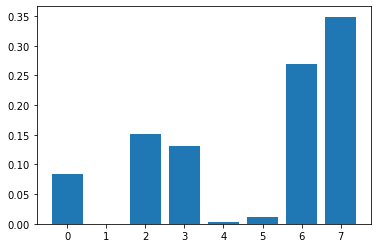

In [27]:
from matplotlib import pyplot
# get importance
importance = rf_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
#pyplot.xticks(len(importance), df2.columns)
pyplot.show()

In [28]:
# Sort features by their importance
sorted(zip(rf_model.feature_importances_, df2.columns), reverse=True)

[(0.348952241126675, 'Event'),
 (0.26954049082714887, 'Sport'),
 (0.15146364618581426, 'GDP'),
 (0.1307795926763044, 'Population'),
 (0.08468679190197309, 'NOC'),
 (0.01104281648294871, 'Summer'),
 (0.00353442079913581, 'Home_Field_Adv'),
 (0.0, 'Male')]

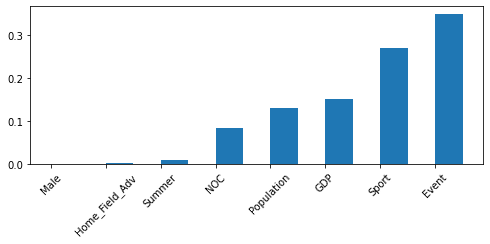

In [29]:
#Sort them and present them as a list
sorted_labels = sorted(zip(df2.columns, rf_model.feature_importances_))#, reverse=True)
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.bar(*zip(* sorted(sorted_labels,key=lambda x: x[1] )),align='edge',width=0.5)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()    

# if you wanted to load Neural Network model

In [30]:
from keras.models import load_model

# returns a compiled model
# identical to the previous one
# model = load_model('../Resources/PredictiveOlympicsGDP_Event.h5')

# if you want to load RandomForest model

In [31]:
# load, no need to initialize the loaded_rf
#loaded_rf = joblib.load("../Resources/random_forest_PredictiveOlympicsGDP_Event.joblib")